In [35]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statistics

sns.set()
# sns.set_context('paper', font_scale=0.73)
sns.set_context('paper', font_scale=1.3)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

In [36]:
!echo $CONDA_DEFAULT_ENV

In [37]:
#paths
root_dir = "/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_tradeoff"
group_folder = "run"
exp_name= ["pile1e8_20len"]
seed_name = ["seed0", "seed1", "seed2", "seed3", "seed4"]
model_sizes = ["70M"]
scored_file = "loss_per_token_scored_watermark_losses.csv"
scored_null_file = "loss_per_token_scored_null_losses.csv"
num_null_seq = 1000

#these are the tokens that we will be averaging the losses to get our statistic
start_attend = 0
end_attend = 100

experiments = [f"{root_dir}/{group_folder}/{exp}_{seed}/{model_size}" for model_size in model_sizes for exp in exp_name for seed in seed_name]
experiments

['/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_tradeoff/run/pile1e8_20len_seed0/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_tradeoff/run/pile1e8_20len_seed1/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_tradeoff/run/pile1e8_20len_seed2/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_tradeoff/run/pile1e8_20len_seed3/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_tradeoff/run/pile1e8_20len_seed4/70M']

In [38]:
models = list(filter(lambda x: x[-5:] == "model", os.listdir(experiments[0])))
models = sorted(models, key = lambda x: eval(x[:-6]))
temp_models = []
for model in models:
    temp_models += [model]
models = temp_models
models


['1_model',
 '2_model',
 '4_model',
 '8_model',
 '16_model',
 '32_model',
 '64_model',
 '128_model',
 '256_model']

In [39]:
def read_file(file_name):
    data = []
    with open(file_name, 'r') as file:
        for line in file:
            row = [eval(element.strip()) for element in line.split(",")]
            data.append(row[start_attend:end_attend])
    return data

In [40]:
experiments_watermark = []
experiments_null = []
for experiment in experiments:
    total_dfs_watermark = []
    total_dfs_null = []
    for model_type in models:
        total_dfs_watermark += [read_file(os.path.join(experiment, model_type, scored_file))]
        total_dfs_null += [read_file(os.path.join(experiment, model_type, scored_null_file))]
    experiments_watermark.append(total_dfs_watermark)
    experiments_null.append(total_dfs_null)
    
#both have dimensions (seed, repetitions, unique_watermarks * 1000)
print(len(experiments_watermark))
print(len(experiments_watermark[0]))

5
9


In [45]:

experiments_null_mean_distribution = []

#loop over the seeds
for experiment_id in range(len(experiments)):
    total_null_means = []
    
    #loop over the repetitions
    for null_raw in experiments_null[experiment_id]:
        #we first take the mean of each watermark in the null distribution
        null_distr = [statistics.mean(row) for row in null_raw]
        #each sample is the mean of all existing watermarks
        num_per_sample = len(null_distr) // num_null_seq
        null_means = []
        for i in range(num_null_seq):
            curr_sample = null_distr[i * num_per_sample: (i+1) * num_per_sample]
            null_means += [statistics.mean(curr_sample)]
        total_null_means += [null_means]
    experiments_null_mean_distribution.append(total_null_means)
print(np.array(experiments_null_mean_distribution).shape)


(5, 9, 1000)


In [46]:
experiments_watermark_mean = []

#loop over the seeds
for experiment_id in range(len(experiments)):
    total_means = []
    
    #loop over the repetitions
    for watermark_raw in experiments_watermark[experiment_id]:
        #we first take the mean of each watermark in the null distribution
        watermark_sample = [statistics.mean(row) for row in watermark_raw]
        total_means += [statistics.mean(watermark_sample)]
    
    experiments_watermark_mean.append(total_means)
print(np.array(experiments_watermark_mean).shape)



(5, 9)


In [47]:
print(experiments_watermark_mean)

[[6.873168431690092, 6.769469018401381, 6.665086010965572, 6.316342603486602, 5.734150947535232, 4.6043921619170485, 3.1870512311297663, 1.8137596748960325, 0.9854341951700357], [6.855780821165771, 6.878538100902515, 6.604922318816523, 6.1287264534811055, 5.832477602165303, 4.6191705164001, 2.9599277065031204, 1.7038142339858626, 1.6363976248539984], [6.778281199797923, 6.666540381777346, 6.5444180599391055, 6.367562527090876, 5.791861982632621, 4.607954982102585, 3.2675691385202823, 1.7505871640961796, 1.1760016060434282], [6.814144454324653, 6.669235748627458, 6.584743045057057, 6.233252725642094, 5.531124558683585, 4.346252332582816, 2.4022197585919676, 1.7529983098178894, 1.4794082269072533], [6.809188179437042, 6.696430683926451, 6.540300200246984, 6.357028827931689, 5.594036643969545, 4.105044473079109, 2.7625917137221814, 1.3467378308894216, 0.5900547664080348]]


In [48]:
print(np.mean(np.array(experiments_null_mean_distribution[0]), axis = 1))
print(np.std(np.array(experiments_null_mean_distribution[0]), axis = 1))


[6.89492002 6.85199914 6.92651278 6.98997836 7.19524924 7.28974546
 7.61766217 7.71597465 7.54364965]
[0.04234072 0.06119608 0.08722793 0.11861732 0.16898071 0.23410518
 0.37104112 0.55154442 0.77260058]


In [49]:
#we now get the z-score

experiment_z_scores = []

for experiment_id in range(len(experiments)):
    
    curr_z_scores = []

    for watermark_ind in range(len(experiments_watermark_mean[experiment_id])):
        null_distr = np.array(experiments_null_mean_distribution[experiment_id][watermark_ind])
        watermark_score = experiments_watermark_mean[experiment_id][watermark_ind]
        
        curr_z_scores += [(watermark_score - null_distr.mean()) / null_distr.std()]
    
    experiment_z_scores.append(curr_z_scores)

print(np.array(experiment_z_scores).shape)

(5, 9)


In [56]:
x = [1, 2, 4, 8, 16, 32, 64, 128, 256]

In [78]:
y = np.array(experiment_z_scores).mean(axis=0)

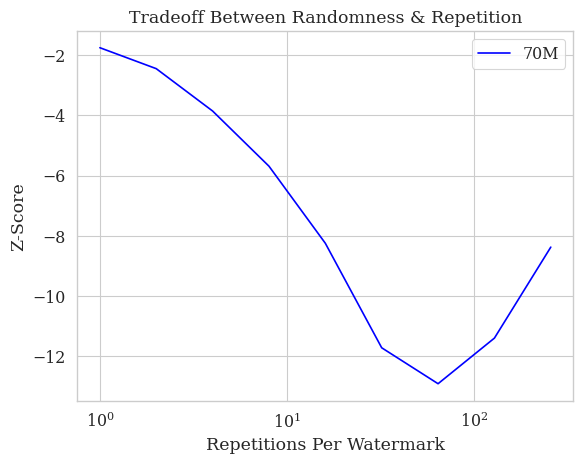

In [80]:
# Create a line plot for each set of y-values
ax = sns.lineplot(x=x, y=y, color='blue', label='70M')

# Customize the plot
plt.title('Tradeoff Between Randomness & Repetition')
plt.xlabel('Repetitions Per Watermark')
plt.ylabel('Z-Score')
plt.legend()

ax.set_xscale("log")

# Show the plot
plt.show()

In [75]:
np.array(experiments_null_mean_distribution).mean(axis=(0, 2))

array([6.90334044, 6.88639932, 6.91929656, 6.96880676, 7.06825246,
       7.20616204, 7.5108496 , 7.5959452 , 7.64021694])

In [71]:
null_mean_plot = np.mean(np.array(experiments_null_mean_distribution).mean(axis=0), axis = 1)
null_std_plot = np.std(np.array(experiments_null_mean_distribution).mean(axis=0), axis = 1)
test_statistic_plot = np.array(experiments_watermark_mean).mean(axis=0)


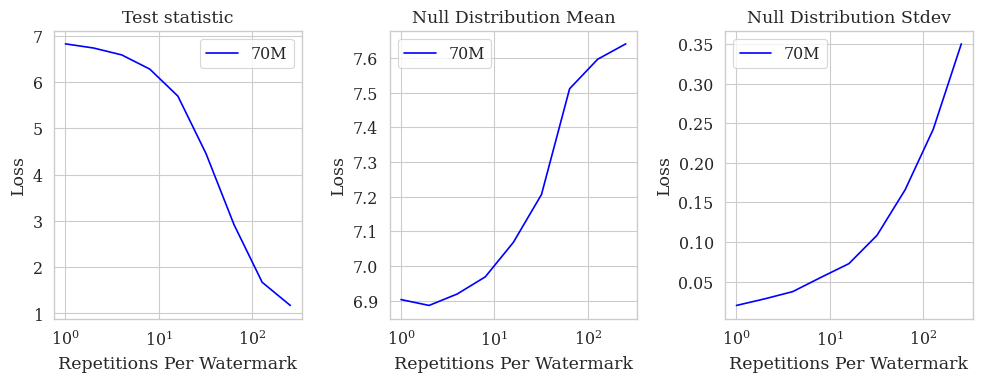

In [82]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)  # 1 row, 2 columns, 1st subplot
ax = sns.lineplot(x=x, y=test_statistic_plot, color='blue', label="70M")
plt.xlabel('Repetitions Per Watermark')
plt.ylabel('Loss')
ax.set_xscale("log")
plt.title('Test statistic')

plt.subplot(1, 3, 2)  # 1 row, 2 columns, 1st subplot
ax = sns.lineplot(x=x, y=null_mean_plot, color='blue', label="70M")
plt.xlabel('Repetitions Per Watermark')
plt.ylabel('Loss')
ax.set_xscale("log")
plt.title('Null Distribution Mean')

# Creating the second plot (Bar plot)
plt.subplot(1, 3, 3)  # 1 row, 2 columns, 2nd subplot
ax = sns.lineplot(x=x, y=null_std_plot, color='blue', label="70M")
plt.xlabel('Repetitions Per Watermark')
plt.ylabel('Loss')
ax.set_xscale("log")
plt.title('Null Distribution Stdev')

plt.tight_layout()
plt.show()